In [3]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


In [5]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')


   16384/84125825 [..............................] - ETA: 0s


   73728/84125825 [..............................] - ETA: 1:05


  237568/84125825 [..............................] - ETA: 40s 


  516096/84125825 [..............................] - ETA: 28s


  991232/84125825 [..............................] - ETA: 19s


 1794048/84125825 [..............................] - ETA: 13s


 3153920/84125825 [>.............................] - ETA: 8s 


 5545984/84125825 [>.............................] - ETA: 5s


 8126464/84125825 [=>............................] - ETA: 4s


11689984/84125825 [===>..........................] - ETA: 3s


15261696/84125825 [====>.........................] - ETA: 2s


19587072/84125825 [=====>........................] - ETA: 1s


24174592/84125825 [=======>......................] - ETA: 1s


29089792/84125825 [=========>....................] - ETA: 1s


34201600/84125825 [===========>..................] - ETA: 1s


39297024/84125825 [=============>................] - ETA: 0s


44097536/84125825 [==============>...............] - ETA: 0s


49053696/84125825 [================>.............] - ETA: 0s


54304768/84125825 [==================>...........] - ETA: 0s


59138048/84125825 [====================>.........] - ETA: 0s


63987712/84125825 [=====================>........] - ETA: 0s


68853760/84125825 [=======================>......] - ETA: 0s


73818112/84125825 [=========================>....] - ETA: 0s


78618624/84125825 [===========================>..] - ETA: 0s


83550208/84125825 [============================>.] - ETA: 0s


84131840/84125825 [==============================] - 1s 0us/step



84140032/84125825 [==============================] - 1s 0us/step


In [6]:
os.listdir(dataset_dir)

['imdbEr.txt', 'README', 'train', 'test', 'imdb.vocab']

In [7]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'urls_pos.txt',
 'urls_unsup.txt',
 'unsup',
 'pos',
 'unsupBow.feat',
 'urls_neg.txt',
 'neg']

In [8]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [9]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [10]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [11]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [12]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [13]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [14]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


In [15]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [16]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [17]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [18]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [19]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [20]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [21]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [23]:
embedding_dim = 16

In [24]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

In [25]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [26]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10



  1/625 [..............................] - ETA: 9:01 - loss: 0.6941 - binary_accuracy: 0.3438


 14/625 [..............................] - ETA: 2s - loss: 0.6930 - binary_accuracy: 0.5312  


 28/625 [>.............................] - ETA: 2s - loss: 0.6928 - binary_accuracy: 0.5402


 43/625 [=>............................] - ETA: 2s - loss: 0.6928 - binary_accuracy: 0.5269


 58/625 [=>............................] - ETA: 2s - loss: 0.6924 - binary_accuracy: 0.5420


 72/625 [==>...........................] - ETA: 2s - loss: 0.6921 - binary_accuracy: 0.5395


 87/625 [===>..........................] - ETA: 1s - loss: 0.6918 - binary_accuracy: 0.5359


101/625 [===>..........................] - ETA: 1s - loss: 0.6918 - binary_accuracy: 0.5248


116/625 [====>.........................] - ETA: 1s - loss: 0.6916 - binary_accuracy: 0.5218


131/625 [=====>........................] - ETA: 1s - loss: 0.6913 - binary_accuracy: 0.5389


146/625 [======>.......................] - ETA: 1s - loss: 0.6910 - binary_accuracy: 0.5569


161/625 [======>.......................] - ETA: 1s - loss: 0.6908 - binary_accuracy: 0.5705


176/625 [=======>......................] - ETA: 1s - loss: 0.6903 - binary_accuracy: 0.5831


191/625 [========>.....................] - ETA: 1s - loss: 0.6899 - binary_accuracy: 0.5859


206/625 [========>.....................] - ETA: 1s - loss: 0.6897 - binary_accuracy: 0.5843


221/625 [=========>....................] - ETA: 1s - loss: 0.6892 - binary_accuracy: 0.5932


236/625 [==========>...................] - ETA: 1s - loss: 0.6886 - binary_accuracy: 0.6025


250/625 [===========>..................] - ETA: 1s - loss: 0.6881 - binary_accuracy: 0.6105


264/625 [===========>..................] - ETA: 1s - loss: 0.6875 - binary_accuracy: 0.6173


279/625 [============>.................] - ETA: 1s - loss: 0.6868 - binary_accuracy: 0.6222


294/625 [=============>................] - ETA: 1s - loss: 0.6864 - binary_accuracy: 0.6257


309/625 [=============>................] - ETA: 1s - loss: 0.6857 - binary_accuracy: 0.6310


324/625 [==============>...............] - ETA: 1s - loss: 0.6851 - binary_accuracy: 0.6343


339/625 [===============>..............] - ETA: 1s - loss: 0.6844 - binary_accuracy: 0.6386


354/625 [===============>..............] - ETA: 0s - loss: 0.6838 - binary_accuracy: 0.6407


368/625 [================>.............] - ETA: 0s - loss: 0.6830 - binary_accuracy: 0.6453


383/625 [=================>............] - ETA: 0s - loss: 0.6821 - binary_accuracy: 0.6504


398/625 [==================>...........] - ETA: 0s - loss: 0.6811 - binary_accuracy: 0.6553


413/625 [==================>...........] - ETA: 0s - loss: 0.6802 - binary_accuracy: 0.6591


428/625 [===================>..........] - ETA: 0s - loss: 0.6792 - binary_accuracy: 0.6635


443/625 [====================>.........] - ETA: 0s - loss: 0.6783 - binary_accuracy: 0.6663


458/625 [====================>.........] - ETA: 0s - loss: 0.6773 - binary_accuracy: 0.6693


473/625 [=====================>........] - ETA: 0s - loss: 0.6765 - binary_accuracy: 0.6710


488/625 [======================>.......] - ETA: 0s - loss: 0.6753 - binary_accuracy: 0.6737


502/625 [=======================>......] - ETA: 0s - loss: 0.6743 - binary_accuracy: 0.6764


518/625 [=======================>......] - ETA: 0s - loss: 0.6732 - binary_accuracy: 0.6789


533/625 [========================>.....] - ETA: 0s - loss: 0.6721 - binary_accuracy: 0.6809


548/625 [=========================>....] - ETA: 0s - loss: 0.6711 - binary_accuracy: 0.6834


563/625 [==========================>...] - ETA: 0s - loss: 0.6699 - binary_accuracy: 0.6857


579/625 [==========================>...] - ETA: 0s - loss: 0.6688 - binary_accuracy: 0.6874


594/625 [===========================>..] - ETA: 0s - loss: 0.6675 - binary_accuracy: 0.6900


609/625 [============================>.] - ETA: 0s - loss: 0.6663 - binary_accuracy: 0.6922


625/625 [==============================] - ETA: 0s - loss: 0.6650 - binary_accuracy: 0.6944


625/625 [==============================] - 3s 4ms/step - loss: 0.6650 - binary_accuracy: 0.6944 - val_loss: 0.6150 - val_binary_accuracy: 0.7728


Epoch 2/10

  1/625 [..............................] - ETA: 2s - loss: 0.5772 - binary_accuracy: 0.8125


 18/625 [..............................] - ETA: 1s - loss: 0.6093 - binary_accuracy: 0.7656


 34/625 [>.............................] - ETA: 1s - loss: 0.6085 - binary_accuracy: 0.7638


 51/625 [=>............................] - ETA: 1s - loss: 0.6060 - binary_accuracy: 0.7672


 68/625 [==>...........................] - ETA: 1s - loss: 0.6048 - binary_accuracy: 0.7693


 85/625 [===>..........................] - ETA: 1s - loss: 0.6025 - binary_accuracy: 0.7669


102/625 [===>..........................] - ETA: 1s - loss: 0.6013 - binary_accuracy: 0.7702


119/625 [====>.........................] - ETA: 1s - loss: 0.6005 - binary_accuracy: 0.7702


136/625 [=====>........................] - ETA: 1s - loss: 0.5982 - binary_accuracy: 0.7723


153/625 [======>.......................] - ETA: 1s - loss: 0.5970 - binary_accuracy: 0.7725


169/625 [=======>......................] - ETA: 1s - loss: 0.5948 - binary_accuracy: 0.7753


186/625 [=======>......................] - ETA: 1s - loss: 0.5937 - binary_accuracy: 0.7750


203/625 [========>.....................] - ETA: 1s - loss: 0.5922 - binary_accuracy: 0.7752


219/625 [=========>....................] - ETA: 1s - loss: 0.5903 - binary_accuracy: 0.7770


236/625 [==========>...................] - ETA: 1s - loss: 0.5884 - binary_accuracy: 0.7775


253/625 [===========>..................] - ETA: 1s - loss: 0.5859 - binary_accuracy: 0.7798


269/625 [===========>..................] - ETA: 1s - loss: 0.5832 - binary_accuracy: 0.7823


286/625 [============>.................] - ETA: 1s - loss: 0.5817 - binary_accuracy: 0.7825


304/625 [=============>................] - ETA: 0s - loss: 0.5802 - binary_accuracy: 0.7825


320/625 [==============>...............] - ETA: 0s - loss: 0.5791 - binary_accuracy: 0.7818


337/625 [===============>..............] - ETA: 0s - loss: 0.5775 - binary_accuracy: 0.7828


354/625 [===============>..............] - ETA: 0s - loss: 0.5761 - binary_accuracy: 0.7835


371/625 [================>.............] - ETA: 0s - loss: 0.5739 - binary_accuracy: 0.7856


388/625 [=================>............] - ETA: 0s - loss: 0.5717 - binary_accuracy: 0.7875


405/625 [==================>...........] - ETA: 0s - loss: 0.5693 - binary_accuracy: 0.7892


422/625 [===================>..........] - ETA: 0s - loss: 0.5669 - binary_accuracy: 0.7904


439/625 [====================>.........] - ETA: 0s - loss: 0.5654 - binary_accuracy: 0.7912


456/625 [====================>.........] - ETA: 0s - loss: 0.5636 - binary_accuracy: 0.7920


473/625 [=====================>........] - ETA: 0s - loss: 0.5622 - binary_accuracy: 0.7928


489/625 [======================>.......] - ETA: 0s - loss: 0.5603 - binary_accuracy: 0.7941


505/625 [=======================>......] - ETA: 0s - loss: 0.5587 - binary_accuracy: 0.7948


521/625 [========================>.....] - ETA: 0s - loss: 0.5569 - binary_accuracy: 0.7962


538/625 [========================>.....] - ETA: 0s - loss: 0.5557 - binary_accuracy: 0.7964


554/625 [=========================>....] - ETA: 0s - loss: 0.5542 - binary_accuracy: 0.7973


571/625 [==========================>...] - ETA: 0s - loss: 0.5524 - binary_accuracy: 0.7982


588/625 [===========================>..] - ETA: 0s - loss: 0.5513 - binary_accuracy: 0.7983


605/625 [============================>.] - ETA: 0s - loss: 0.5495 - binary_accuracy: 0.7996


621/625 [============================>.] - ETA: 0s - loss: 0.5482 - binary_accuracy: 0.8001


625/625 [==============================] - 2s 3ms/step - loss: 0.5478 - binary_accuracy: 0.8003 - val_loss: 0.4973 - val_binary_accuracy: 0.8224


Epoch 3/10

  1/625 [..............................] - ETA: 2s - loss: 0.4310 - binary_accuracy: 0.8750


 18/625 [..............................] - ETA: 1s - loss: 0.4845 - binary_accuracy: 0.8368


 34/625 [>.............................] - ETA: 1s - loss: 0.4840 - binary_accuracy: 0.8272


 50/625 [=>............................] - ETA: 1s - loss: 0.4836 - binary_accuracy: 0.8300


 67/625 [==>...........................] - ETA: 1s - loss: 0.4821 - binary_accuracy: 0.8298


 83/625 [==>...........................] - ETA: 1s - loss: 0.4809 - binary_accuracy: 0.8261


 99/625 [===>..........................] - ETA: 1s - loss: 0.4807 - binary_accuracy: 0.8251


116/625 [====>.........................] - ETA: 1s - loss: 0.4783 - binary_accuracy: 0.8284


132/625 [=====>........................] - ETA: 1s - loss: 0.4772 - binary_accuracy: 0.8281


149/625 [======>.......................] - ETA: 1s - loss: 0.4772 - binary_accuracy: 0.8263


166/625 [======>.......................] - ETA: 1s - loss: 0.4759 - binary_accuracy: 0.8293


183/625 [=======>......................] - ETA: 1s - loss: 0.4741 - binary_accuracy: 0.8292


200/625 [========>.....................] - ETA: 1s - loss: 0.4747 - binary_accuracy: 0.8288


216/625 [=========>....................] - ETA: 1s - loss: 0.4732 - binary_accuracy: 0.8297


233/625 [==========>...................] - ETA: 1s - loss: 0.4715 - binary_accuracy: 0.8309


250/625 [===========>..................] - ETA: 1s - loss: 0.4688 - binary_accuracy: 0.8328


267/625 [===========>..................] - ETA: 1s - loss: 0.4668 - binary_accuracy: 0.8347


284/625 [============>.................] - ETA: 1s - loss: 0.4660 - binary_accuracy: 0.8357


301/625 [=============>................] - ETA: 0s - loss: 0.4662 - binary_accuracy: 0.8343


318/625 [==============>...............] - ETA: 0s - loss: 0.4654 - binary_accuracy: 0.8343


335/625 [===============>..............] - ETA: 0s - loss: 0.4645 - binary_accuracy: 0.8347


352/625 [===============>..............] - ETA: 0s - loss: 0.4635 - binary_accuracy: 0.8349


368/625 [================>.............] - ETA: 0s - loss: 0.4620 - binary_accuracy: 0.8361


385/625 [=================>............] - ETA: 0s - loss: 0.4604 - binary_accuracy: 0.8375


401/625 [==================>...........] - ETA: 0s - loss: 0.4586 - binary_accuracy: 0.8391


417/625 [===================>..........] - ETA: 0s - loss: 0.4570 - binary_accuracy: 0.8401


434/625 [===================>..........] - ETA: 0s - loss: 0.4556 - binary_accuracy: 0.8407


451/625 [====================>.........] - ETA: 0s - loss: 0.4545 - binary_accuracy: 0.8408


468/625 [=====================>........] - ETA: 0s - loss: 0.4529 - binary_accuracy: 0.8420


485/625 [======================>.......] - ETA: 0s - loss: 0.4523 - binary_accuracy: 0.8420


501/625 [=======================>......] - ETA: 0s - loss: 0.4507 - binary_accuracy: 0.8434


518/625 [=======================>......] - ETA: 0s - loss: 0.4494 - binary_accuracy: 0.8441


535/625 [========================>.....] - ETA: 0s - loss: 0.4487 - binary_accuracy: 0.8441


552/625 [=========================>....] - ETA: 0s - loss: 0.4477 - binary_accuracy: 0.8444


569/625 [==========================>...] - ETA: 0s - loss: 0.4465 - binary_accuracy: 0.8448


586/625 [===========================>..] - ETA: 0s - loss: 0.4461 - binary_accuracy: 0.8447


603/625 [===========================>..] - ETA: 0s - loss: 0.4449 - binary_accuracy: 0.8456


620/625 [============================>.] - ETA: 0s - loss: 0.4445 - binary_accuracy: 0.8450


625/625 [==============================] - 2s 3ms/step - loss: 0.4440 - binary_accuracy: 0.8451 - val_loss: 0.4195 - val_binary_accuracy: 0.8466


Epoch 4/10

  1/625 [..............................] - ETA: 2s - loss: 0.3586 - binary_accuracy: 0.9062


 18/625 [..............................] - ETA: 1s - loss: 0.3979 - binary_accuracy: 0.8628


 35/625 [>.............................] - ETA: 1s - loss: 0.4010 - binary_accuracy: 0.8598


 52/625 [=>............................] - ETA: 1s - loss: 0.4004 - binary_accuracy: 0.8588


 69/625 [==>...........................] - ETA: 1s - loss: 0.4021 - binary_accuracy: 0.8591


 85/625 [===>..........................] - ETA: 1s - loss: 0.3987 - binary_accuracy: 0.8592


101/625 [===>..........................] - ETA: 1s - loss: 0.4003 - binary_accuracy: 0.8577


118/625 [====>.........................] - ETA: 1s - loss: 0.3984 - binary_accuracy: 0.8578


135/625 [=====>........................] - ETA: 1s - loss: 0.3969 - binary_accuracy: 0.8565


152/625 [======>.......................] - ETA: 1s - loss: 0.3980 - binary_accuracy: 0.8555


169/625 [=======>......................] - ETA: 1s - loss: 0.3967 - binary_accuracy: 0.8571


185/625 [=======>......................] - ETA: 1s - loss: 0.3957 - binary_accuracy: 0.8579


201/625 [========>.....................] - ETA: 1s - loss: 0.3967 - binary_accuracy: 0.8574


218/625 [=========>....................] - ETA: 1s - loss: 0.3956 - binary_accuracy: 0.8589


235/625 [==========>...................] - ETA: 1s - loss: 0.3953 - binary_accuracy: 0.8584


252/625 [===========>..................] - ETA: 1s - loss: 0.3925 - binary_accuracy: 0.8595


269/625 [===========>..................] - ETA: 1s - loss: 0.3910 - binary_accuracy: 0.8615


286/625 [============>.................] - ETA: 1s - loss: 0.3915 - binary_accuracy: 0.8605


302/625 [=============>................] - ETA: 0s - loss: 0.3920 - binary_accuracy: 0.8595


319/625 [==============>...............] - ETA: 0s - loss: 0.3919 - binary_accuracy: 0.8591


336/625 [===============>..............] - ETA: 0s - loss: 0.3913 - binary_accuracy: 0.8595


353/625 [===============>..............] - ETA: 0s - loss: 0.3905 - binary_accuracy: 0.8594


369/625 [================>.............] - ETA: 0s - loss: 0.3890 - binary_accuracy: 0.8606


386/625 [=================>............] - ETA: 0s - loss: 0.3879 - binary_accuracy: 0.8612


403/625 [==================>...........] - ETA: 0s - loss: 0.3860 - binary_accuracy: 0.8624


419/625 [===================>..........] - ETA: 0s - loss: 0.3848 - binary_accuracy: 0.8631


436/625 [===================>..........] - ETA: 0s - loss: 0.3838 - binary_accuracy: 0.8637


453/625 [====================>.........] - ETA: 0s - loss: 0.3828 - binary_accuracy: 0.8638


470/625 [=====================>........] - ETA: 0s - loss: 0.3823 - binary_accuracy: 0.8646


487/625 [======================>.......] - ETA: 0s - loss: 0.3820 - binary_accuracy: 0.8645


504/625 [=======================>......] - ETA: 0s - loss: 0.3805 - binary_accuracy: 0.8657


521/625 [========================>.....] - ETA: 0s - loss: 0.3793 - binary_accuracy: 0.8661


538/625 [========================>.....] - ETA: 0s - loss: 0.3793 - binary_accuracy: 0.8659


555/625 [=========================>....] - ETA: 0s - loss: 0.3788 - binary_accuracy: 0.8664


572/625 [==========================>...] - ETA: 0s - loss: 0.3779 - binary_accuracy: 0.8671


589/625 [===========================>..] - ETA: 0s - loss: 0.3783 - binary_accuracy: 0.8662


606/625 [============================>.] - ETA: 0s - loss: 0.3779 - binary_accuracy: 0.8666


623/625 [============================>.] - ETA: 0s - loss: 0.3777 - binary_accuracy: 0.8660


625/625 [==============================] - 2s 3ms/step - loss: 0.3774 - binary_accuracy: 0.8662 - val_loss: 0.3733 - val_binary_accuracy: 0.8624


Epoch 5/10

  1/625 [..............................] - ETA: 2s - loss: 0.3254 - binary_accuracy: 0.9062


 18/625 [..............................] - ETA: 1s - loss: 0.3448 - binary_accuracy: 0.8802


 35/625 [>.............................] - ETA: 1s - loss: 0.3478 - binary_accuracy: 0.8750


 51/625 [=>............................] - ETA: 1s - loss: 0.3479 - binary_accuracy: 0.8738


 68/625 [==>...........................] - ETA: 1s - loss: 0.3462 - binary_accuracy: 0.8759


 85/625 [===>..........................] - ETA: 1s - loss: 0.3462 - binary_accuracy: 0.8757


102/625 [===>..........................] - ETA: 1s - loss: 0.3490 - binary_accuracy: 0.8741


118/625 [====>.........................] - ETA: 1s - loss: 0.3478 - binary_accuracy: 0.8729


135/625 [=====>........................] - ETA: 1s - loss: 0.3467 - binary_accuracy: 0.8727


152/625 [======>.......................] - ETA: 1s - loss: 0.3479 - binary_accuracy: 0.8719


169/625 [=======>......................] - ETA: 1s - loss: 0.3468 - binary_accuracy: 0.8739


186/625 [=======>......................] - ETA: 1s - loss: 0.3463 - binary_accuracy: 0.8742


203/625 [========>.....................] - ETA: 1s - loss: 0.3470 - binary_accuracy: 0.8732


220/625 [=========>....................] - ETA: 1s - loss: 0.3458 - binary_accuracy: 0.8747


237/625 [==========>...................] - ETA: 1s - loss: 0.3472 - binary_accuracy: 0.8734


254/625 [===========>..................] - ETA: 1s - loss: 0.3454 - binary_accuracy: 0.8744


271/625 [============>.................] - ETA: 1s - loss: 0.3427 - binary_accuracy: 0.8770


288/625 [============>.................] - ETA: 1s - loss: 0.3442 - binary_accuracy: 0.8757


305/625 [=============>................] - ETA: 0s - loss: 0.3449 - binary_accuracy: 0.8743


322/625 [==============>...............] - ETA: 0s - loss: 0.3453 - binary_accuracy: 0.8737


339/625 [===============>..............] - ETA: 0s - loss: 0.3441 - binary_accuracy: 0.8744


356/625 [================>.............] - ETA: 0s - loss: 0.3438 - binary_accuracy: 0.8741


373/625 [================>.............] - ETA: 0s - loss: 0.3422 - binary_accuracy: 0.8753


390/625 [=================>............] - ETA: 0s - loss: 0.3412 - binary_accuracy: 0.8759


406/625 [==================>...........] - ETA: 0s - loss: 0.3400 - binary_accuracy: 0.8765


423/625 [===================>..........] - ETA: 0s - loss: 0.3388 - binary_accuracy: 0.8772


440/625 [====================>.........] - ETA: 0s - loss: 0.3378 - binary_accuracy: 0.8774


457/625 [====================>.........] - ETA: 0s - loss: 0.3375 - binary_accuracy: 0.8775


475/625 [=====================>........] - ETA: 0s - loss: 0.3379 - binary_accuracy: 0.8778


492/625 [======================>.......] - ETA: 0s - loss: 0.3366 - binary_accuracy: 0.8789


509/625 [=======================>......] - ETA: 0s - loss: 0.3352 - binary_accuracy: 0.8793


526/625 [========================>.....] - ETA: 0s - loss: 0.3351 - binary_accuracy: 0.8790


543/625 [=========================>....] - ETA: 0s - loss: 0.3352 - binary_accuracy: 0.8787


560/625 [=========================>....] - ETA: 0s - loss: 0.3349 - binary_accuracy: 0.8789


577/625 [==========================>...] - ETA: 0s - loss: 0.3348 - binary_accuracy: 0.8787


594/625 [===========================>..] - ETA: 0s - loss: 0.3349 - binary_accuracy: 0.8789


611/625 [============================>.] - ETA: 0s - loss: 0.3353 - binary_accuracy: 0.8787


625/625 [==============================] - 2s 3ms/step - loss: 0.3349 - binary_accuracy: 0.8785 - val_loss: 0.3446 - val_binary_accuracy: 0.8666


Epoch 6/10

  1/625 [..............................] - ETA: 2s - loss: 0.3173 - binary_accuracy: 0.9062


 17/625 [..............................] - ETA: 1s - loss: 0.3052 - binary_accuracy: 0.9099


 33/625 [>.............................] - ETA: 1s - loss: 0.3065 - binary_accuracy: 0.9006


 49/625 [=>............................] - ETA: 1s - loss: 0.3073 - binary_accuracy: 0.8954


 65/625 [==>...........................] - ETA: 1s - loss: 0.3088 - binary_accuracy: 0.8952


 81/625 [==>...........................] - ETA: 1s - loss: 0.3115 - binary_accuracy: 0.8908


 97/625 [===>..........................] - ETA: 1s - loss: 0.3149 - binary_accuracy: 0.8898


113/625 [====>.........................] - ETA: 1s - loss: 0.3129 - binary_accuracy: 0.8886


129/625 [=====>........................] - ETA: 1s - loss: 0.3143 - binary_accuracy: 0.8874


145/625 [=====>........................] - ETA: 1s - loss: 0.3139 - binary_accuracy: 0.8856


160/625 [======>.......................] - ETA: 1s - loss: 0.3163 - binary_accuracy: 0.8836


177/625 [=======>......................] - ETA: 1s - loss: 0.3136 - binary_accuracy: 0.8859


193/625 [========>.....................] - ETA: 1s - loss: 0.3129 - binary_accuracy: 0.8854


210/625 [=========>....................] - ETA: 1s - loss: 0.3143 - binary_accuracy: 0.8854


227/625 [=========>....................] - ETA: 1s - loss: 0.3143 - binary_accuracy: 0.8852


244/625 [==========>...................] - ETA: 1s - loss: 0.3141 - binary_accuracy: 0.8850


261/625 [===========>..................] - ETA: 1s - loss: 0.3124 - binary_accuracy: 0.8866


278/625 [============>.................] - ETA: 1s - loss: 0.3099 - binary_accuracy: 0.8885


295/625 [=============>................] - ETA: 1s - loss: 0.3136 - binary_accuracy: 0.8853


312/625 [=============>................] - ETA: 0s - loss: 0.3131 - binary_accuracy: 0.8856


329/625 [==============>...............] - ETA: 0s - loss: 0.3130 - binary_accuracy: 0.8863


346/625 [===============>..............] - ETA: 0s - loss: 0.3124 - binary_accuracy: 0.8858


363/625 [================>.............] - ETA: 0s - loss: 0.3111 - binary_accuracy: 0.8867


381/625 [=================>............] - ETA: 0s - loss: 0.3102 - binary_accuracy: 0.8871


398/625 [==================>...........] - ETA: 0s - loss: 0.3096 - binary_accuracy: 0.8872


415/625 [==================>...........] - ETA: 0s - loss: 0.3085 - binary_accuracy: 0.8882


432/625 [===================>..........] - ETA: 0s - loss: 0.3073 - binary_accuracy: 0.8883


450/625 [====================>.........] - ETA: 0s - loss: 0.3070 - binary_accuracy: 0.8881


467/625 [=====================>........] - ETA: 0s - loss: 0.3062 - binary_accuracy: 0.8888


484/625 [======================>.......] - ETA: 0s - loss: 0.3069 - binary_accuracy: 0.8884


501/625 [=======================>......] - ETA: 0s - loss: 0.3055 - binary_accuracy: 0.8893


518/625 [=======================>......] - ETA: 0s - loss: 0.3047 - binary_accuracy: 0.8896


536/625 [========================>.....] - ETA: 0s - loss: 0.3051 - binary_accuracy: 0.8889


553/625 [=========================>....] - ETA: 0s - loss: 0.3048 - binary_accuracy: 0.8891


571/625 [==========================>...] - ETA: 0s - loss: 0.3040 - binary_accuracy: 0.8895


588/625 [===========================>..] - ETA: 0s - loss: 0.3051 - binary_accuracy: 0.8889


605/625 [============================>.] - ETA: 0s - loss: 0.3052 - binary_accuracy: 0.8891


622/625 [============================>.] - ETA: 0s - loss: 0.3052 - binary_accuracy: 0.8891


625/625 [==============================] - 2s 3ms/step - loss: 0.3049 - binary_accuracy: 0.8892 - val_loss: 0.3260 - val_binary_accuracy: 0.8718


Epoch 7/10

  1/625 [..............................] - ETA: 2s - loss: 0.2948 - binary_accuracy: 0.9062


 18/625 [..............................] - ETA: 1s - loss: 0.2817 - binary_accuracy: 0.9167


 35/625 [>.............................] - ETA: 1s - loss: 0.2837 - binary_accuracy: 0.9062


 52/625 [=>............................] - ETA: 1s - loss: 0.2850 - binary_accuracy: 0.9026


 69/625 [==>...........................] - ETA: 1s - loss: 0.2868 - binary_accuracy: 0.9017


 86/625 [===>..........................] - ETA: 1s - loss: 0.2850 - binary_accuracy: 0.9023


103/625 [===>..........................] - ETA: 1s - loss: 0.2900 - binary_accuracy: 0.8975


120/625 [====>.........................] - ETA: 1s - loss: 0.2893 - binary_accuracy: 0.8971


137/625 [=====>........................] - ETA: 1s - loss: 0.2870 - binary_accuracy: 0.8971


154/625 [======>.......................] - ETA: 1s - loss: 0.2900 - binary_accuracy: 0.8949


171/625 [=======>......................] - ETA: 1s - loss: 0.2883 - binary_accuracy: 0.8951


188/625 [========>.....................] - ETA: 1s - loss: 0.2871 - binary_accuracy: 0.8949


205/625 [========>.....................] - ETA: 1s - loss: 0.2887 - binary_accuracy: 0.8938


222/625 [=========>....................] - ETA: 1s - loss: 0.2876 - binary_accuracy: 0.8943


239/625 [==========>...................] - ETA: 1s - loss: 0.2880 - binary_accuracy: 0.8938


256/625 [===========>..................] - ETA: 1s - loss: 0.2870 - binary_accuracy: 0.8943


273/625 [============>.................] - ETA: 1s - loss: 0.2852 - binary_accuracy: 0.8969


290/625 [============>.................] - ETA: 1s - loss: 0.2874 - binary_accuracy: 0.8955


307/625 [=============>................] - ETA: 0s - loss: 0.2880 - binary_accuracy: 0.8954


324/625 [==============>...............] - ETA: 0s - loss: 0.2876 - binary_accuracy: 0.8948


341/625 [===============>..............] - ETA: 0s - loss: 0.2867 - binary_accuracy: 0.8951


358/625 [================>.............] - ETA: 0s - loss: 0.2861 - binary_accuracy: 0.8948


374/625 [================>.............] - ETA: 0s - loss: 0.2854 - binary_accuracy: 0.8957


391/625 [=================>............] - ETA: 0s - loss: 0.2846 - binary_accuracy: 0.8966


408/625 [==================>...........] - ETA: 0s - loss: 0.2836 - binary_accuracy: 0.8971


425/625 [===================>..........] - ETA: 0s - loss: 0.2830 - binary_accuracy: 0.8972


442/625 [====================>.........] - ETA: 0s - loss: 0.2812 - binary_accuracy: 0.8983


459/625 [=====================>........] - ETA: 0s - loss: 0.2814 - binary_accuracy: 0.8977


476/625 [=====================>........] - ETA: 0s - loss: 0.2824 - binary_accuracy: 0.8971


493/625 [======================>.......] - ETA: 0s - loss: 0.2808 - binary_accuracy: 0.8979


511/625 [=======================>......] - ETA: 0s - loss: 0.2800 - binary_accuracy: 0.8982


528/625 [========================>.....] - ETA: 0s - loss: 0.2798 - binary_accuracy: 0.8981


545/625 [=========================>....] - ETA: 0s - loss: 0.2804 - binary_accuracy: 0.8979


562/625 [=========================>....] - ETA: 0s - loss: 0.2795 - binary_accuracy: 0.8984


579/625 [==========================>...] - ETA: 0s - loss: 0.2803 - binary_accuracy: 0.8978


596/625 [===========================>..] - ETA: 0s - loss: 0.2805 - binary_accuracy: 0.8979


613/625 [============================>.] - ETA: 0s - loss: 0.2813 - binary_accuracy: 0.8977


625/625 [==============================] - 2s 3ms/step - loss: 0.2809 - binary_accuracy: 0.8979 - val_loss: 0.3130 - val_binary_accuracy: 0.8730


Epoch 8/10

  1/625 [..............................] - ETA: 2s - loss: 0.2553 - binary_accuracy: 0.9062


 18/625 [..............................] - ETA: 1s - loss: 0.2580 - binary_accuracy: 0.9236


 35/625 [>.............................] - ETA: 1s - loss: 0.2615 - binary_accuracy: 0.9098


 52/625 [=>............................] - ETA: 1s - loss: 0.2626 - binary_accuracy: 0.9075


 69/625 [==>...........................] - ETA: 1s - loss: 0.2654 - binary_accuracy: 0.9062


 87/625 [===>..........................] - ETA: 1s - loss: 0.2634 - binary_accuracy: 0.9066


104/625 [===>..........................] - ETA: 1s - loss: 0.2692 - binary_accuracy: 0.9041


121/625 [====>.........................] - ETA: 1s - loss: 0.2686 - binary_accuracy: 0.9039


138/625 [=====>........................] - ETA: 1s - loss: 0.2667 - binary_accuracy: 0.9024


156/625 [======>.......................] - ETA: 1s - loss: 0.2688 - binary_accuracy: 0.9008


174/625 [=======>......................] - ETA: 1s - loss: 0.2673 - binary_accuracy: 0.9018


191/625 [========>.....................] - ETA: 1s - loss: 0.2665 - binary_accuracy: 0.9020


208/625 [========>.....................] - ETA: 1s - loss: 0.2679 - binary_accuracy: 0.9022


225/625 [=========>....................] - ETA: 1s - loss: 0.2680 - binary_accuracy: 0.9013


242/625 [==========>...................] - ETA: 1s - loss: 0.2686 - binary_accuracy: 0.9003


259/625 [===========>..................] - ETA: 1s - loss: 0.2674 - binary_accuracy: 0.9017


276/625 [============>.................] - ETA: 1s - loss: 0.2655 - binary_accuracy: 0.9035


293/625 [=============>................] - ETA: 0s - loss: 0.2684 - binary_accuracy: 0.9018


310/625 [=============>................] - ETA: 0s - loss: 0.2687 - binary_accuracy: 0.9021


327/625 [==============>...............] - ETA: 0s - loss: 0.2678 - binary_accuracy: 0.9019


344/625 [===============>..............] - ETA: 0s - loss: 0.2670 - binary_accuracy: 0.9020


361/625 [================>.............] - ETA: 0s - loss: 0.2666 - binary_accuracy: 0.9017


379/625 [=================>............] - ETA: 0s - loss: 0.2656 - binary_accuracy: 0.9019


397/625 [==================>...........] - ETA: 0s - loss: 0.2647 - binary_accuracy: 0.9025


414/625 [==================>...........] - ETA: 0s - loss: 0.2639 - binary_accuracy: 0.9032


431/625 [===================>..........] - ETA: 0s - loss: 0.2626 - binary_accuracy: 0.9039


448/625 [====================>.........] - ETA: 0s - loss: 0.2621 - binary_accuracy: 0.9037


465/625 [=====================>........] - ETA: 0s - loss: 0.2613 - binary_accuracy: 0.9038


481/625 [======================>.......] - ETA: 0s - loss: 0.2622 - binary_accuracy: 0.9037


496/625 [======================>.......] - ETA: 0s - loss: 0.2612 - binary_accuracy: 0.9039


511/625 [=======================>......] - ETA: 0s - loss: 0.2603 - binary_accuracy: 0.9047


527/625 [========================>.....] - ETA: 0s - loss: 0.2603 - binary_accuracy: 0.9044


543/625 [=========================>....] - ETA: 0s - loss: 0.2604 - binary_accuracy: 0.9043


559/625 [=========================>....] - ETA: 0s - loss: 0.2603 - binary_accuracy: 0.9047


574/625 [==========================>...] - ETA: 0s - loss: 0.2605 - binary_accuracy: 0.9048


590/625 [===========================>..] - ETA: 0s - loss: 0.2616 - binary_accuracy: 0.9044


605/625 [============================>.] - ETA: 0s - loss: 0.2618 - binary_accuracy: 0.9043


621/625 [============================>.] - ETA: 0s - loss: 0.2622 - binary_accuracy: 0.9040


625/625 [==============================] - 2s 3ms/step - loss: 0.2618 - binary_accuracy: 0.9042 - val_loss: 0.3033 - val_binary_accuracy: 0.8762


Epoch 9/10

  1/625 [..............................] - ETA: 2s - loss: 0.2330 - binary_accuracy: 0.9062


 19/625 [..............................] - ETA: 1s - loss: 0.2402 - binary_accuracy: 0.9145


 36/625 [>.............................] - ETA: 1s - loss: 0.2449 - binary_accuracy: 0.9054


 54/625 [=>............................] - ETA: 1s - loss: 0.2434 - binary_accuracy: 0.9109


 71/625 [==>...........................] - ETA: 1s - loss: 0.2470 - binary_accuracy: 0.9093


 88/625 [===>..........................] - ETA: 1s - loss: 0.2456 - binary_accuracy: 0.9105


105/625 [====>.........................] - ETA: 1s - loss: 0.2508 - binary_accuracy: 0.9089


122/625 [====>.........................] - ETA: 1s - loss: 0.2499 - binary_accuracy: 0.9101


139/625 [=====>........................] - ETA: 1s - loss: 0.2483 - binary_accuracy: 0.9085


156/625 [======>.......................] - ETA: 1s - loss: 0.2518 - binary_accuracy: 0.9062


173/625 [=======>......................] - ETA: 1s - loss: 0.2498 - binary_accuracy: 0.9066


190/625 [========>.....................] - ETA: 1s - loss: 0.2483 - binary_accuracy: 0.9082


206/625 [========>.....................] - ETA: 1s - loss: 0.2498 - binary_accuracy: 0.9079


222/625 [=========>....................] - ETA: 1s - loss: 0.2495 - binary_accuracy: 0.9077


238/625 [==========>...................] - ETA: 1s - loss: 0.2513 - binary_accuracy: 0.9066


255/625 [===========>..................] - ETA: 1s - loss: 0.2503 - binary_accuracy: 0.9067


272/625 [============>.................] - ETA: 1s - loss: 0.2492 - binary_accuracy: 0.9084


288/625 [============>.................] - ETA: 1s - loss: 0.2499 - binary_accuracy: 0.9086


305/625 [=============>................] - ETA: 0s - loss: 0.2504 - binary_accuracy: 0.9085


322/625 [==============>...............] - ETA: 0s - loss: 0.2509 - binary_accuracy: 0.9077


339/625 [===============>..............] - ETA: 0s - loss: 0.2495 - binary_accuracy: 0.9082


356/625 [================>.............] - ETA: 0s - loss: 0.2492 - binary_accuracy: 0.9078


373/625 [================>.............] - ETA: 0s - loss: 0.2478 - binary_accuracy: 0.9090


390/625 [=================>............] - ETA: 0s - loss: 0.2472 - binary_accuracy: 0.9091


407/625 [==================>...........] - ETA: 0s - loss: 0.2460 - binary_accuracy: 0.9095


424/625 [===================>..........] - ETA: 0s - loss: 0.2458 - binary_accuracy: 0.9098


441/625 [====================>.........] - ETA: 0s - loss: 0.2445 - binary_accuracy: 0.9103


458/625 [====================>.........] - ETA: 0s - loss: 0.2445 - binary_accuracy: 0.9103


474/625 [=====================>........] - ETA: 0s - loss: 0.2449 - binary_accuracy: 0.9101


491/625 [======================>.......] - ETA: 0s - loss: 0.2441 - binary_accuracy: 0.9105


508/625 [=======================>......] - ETA: 0s - loss: 0.2428 - binary_accuracy: 0.9112


525/625 [========================>.....] - ETA: 0s - loss: 0.2429 - binary_accuracy: 0.9113


542/625 [=========================>....] - ETA: 0s - loss: 0.2435 - binary_accuracy: 0.9109


559/625 [=========================>....] - ETA: 0s - loss: 0.2433 - binary_accuracy: 0.9114


575/625 [==========================>...] - ETA: 0s - loss: 0.2435 - binary_accuracy: 0.9115


592/625 [===========================>..] - ETA: 0s - loss: 0.2444 - binary_accuracy: 0.9109


609/625 [============================>.] - ETA: 0s - loss: 0.2454 - binary_accuracy: 0.9103


625/625 [==============================] - 2s 3ms/step - loss: 0.2449 - binary_accuracy: 0.9105 - val_loss: 0.2965 - val_binary_accuracy: 0.8786


Epoch 10/10

  1/625 [..............................] - ETA: 2s - loss: 0.2274 - binary_accuracy: 0.9375


 19/625 [..............................] - ETA: 1s - loss: 0.2313 - binary_accuracy: 0.9243


 37/625 [>.............................] - ETA: 1s - loss: 0.2317 - binary_accuracy: 0.9215


 54/625 [=>............................] - ETA: 1s - loss: 0.2294 - binary_accuracy: 0.9196


 71/625 [==>...........................] - ETA: 1s - loss: 0.2319 - binary_accuracy: 0.9168


 88/625 [===>..........................] - ETA: 1s - loss: 0.2321 - binary_accuracy: 0.9180


105/625 [====>.........................] - ETA: 1s - loss: 0.2372 - binary_accuracy: 0.9161


123/625 [====>.........................] - ETA: 1s - loss: 0.2351 - binary_accuracy: 0.9162


140/625 [=====>........................] - ETA: 1s - loss: 0.2334 - binary_accuracy: 0.9165


157/625 [======>.......................] - ETA: 1s - loss: 0.2366 - binary_accuracy: 0.9142


174/625 [=======>......................] - ETA: 1s - loss: 0.2350 - binary_accuracy: 0.9149


191/625 [========>.....................] - ETA: 1s - loss: 0.2343 - binary_accuracy: 0.9151


208/625 [========>.....................] - ETA: 1s - loss: 0.2355 - binary_accuracy: 0.9153


226/625 [=========>....................] - ETA: 1s - loss: 0.2362 - binary_accuracy: 0.9145


243/625 [==========>...................] - ETA: 1s - loss: 0.2371 - binary_accuracy: 0.9132


260/625 [===========>..................] - ETA: 1s - loss: 0.2366 - binary_accuracy: 0.9138


277/625 [============>.................] - ETA: 1s - loss: 0.2343 - binary_accuracy: 0.9150


295/625 [=============>................] - ETA: 0s - loss: 0.2368 - binary_accuracy: 0.9140


312/625 [=============>................] - ETA: 0s - loss: 0.2368 - binary_accuracy: 0.9144


328/625 [==============>...............] - ETA: 0s - loss: 0.2355 - binary_accuracy: 0.9148


345/625 [===============>..............] - ETA: 0s - loss: 0.2352 - binary_accuracy: 0.9147


363/625 [================>.............] - ETA: 0s - loss: 0.2344 - binary_accuracy: 0.9152


380/625 [=================>............] - ETA: 0s - loss: 0.2339 - binary_accuracy: 0.9152


397/625 [==================>...........] - ETA: 0s - loss: 0.2331 - binary_accuracy: 0.9151


415/625 [==================>...........] - ETA: 0s - loss: 0.2324 - binary_accuracy: 0.9159


432/625 [===================>..........] - ETA: 0s - loss: 0.2314 - binary_accuracy: 0.9161


449/625 [====================>.........] - ETA: 0s - loss: 0.2313 - binary_accuracy: 0.9163


466/625 [=====================>........] - ETA: 0s - loss: 0.2308 - binary_accuracy: 0.9165


483/625 [======================>.......] - ETA: 0s - loss: 0.2317 - binary_accuracy: 0.9160


499/625 [======================>.......] - ETA: 0s - loss: 0.2306 - binary_accuracy: 0.9166


515/625 [=======================>......] - ETA: 0s - loss: 0.2297 - binary_accuracy: 0.9173


532/625 [========================>.....] - ETA: 0s - loss: 0.2301 - binary_accuracy: 0.9168


549/625 [=========================>....] - ETA: 0s - loss: 0.2300 - binary_accuracy: 0.9171


566/625 [==========================>...] - ETA: 0s - loss: 0.2298 - binary_accuracy: 0.9175


583/625 [==========================>...] - ETA: 0s - loss: 0.2308 - binary_accuracy: 0.9171


600/625 [===========================>..] - ETA: 0s - loss: 0.2313 - binary_accuracy: 0.9171


617/625 [============================>.] - ETA: 0s - loss: 0.2320 - binary_accuracy: 0.9163


625/625 [==============================] - 2s 3ms/step - loss: 0.2315 - binary_accuracy: 0.9167 - val_loss: 0.2921 - val_binary_accuracy: 0.8804


In [27]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)


  1/782 [..............................] - ETA: 41s - loss: 0.3543 - binary_accuracy: 0.9062


 28/782 [>.............................] - ETA: 1s - loss: 0.3245 - binary_accuracy: 0.8571 


 54/782 [=>............................] - ETA: 1s - loss: 0.3042 - binary_accuracy: 0.8692


 81/782 [==>...........................] - ETA: 1s - loss: 0.2925 - binary_accuracy: 0.8777


109/782 [===>..........................] - ETA: 1s - loss: 0.3043 - binary_accuracy: 0.8736


135/782 [====>.........................] - ETA: 1s - loss: 0.3046 - binary_accuracy: 0.8711


160/782 [=====>........................] - ETA: 1s - loss: 0.3073 - binary_accuracy: 0.8711


186/782 [======>.......................] - ETA: 1s - loss: 0.3074 - binary_accuracy: 0.8701


212/782 [=======>......................] - ETA: 1s - loss: 0.3081 - binary_accuracy: 0.8712


239/782 [========>.....................] - ETA: 1s - loss: 0.3112 - binary_accuracy: 0.8679


266/782 [=========>....................] - ETA: 0s - loss: 0.3098 - binary_accuracy: 0.8694


295/782 [==========>...................] - ETA: 0s - loss: 0.3099 - binary_accuracy: 0.8702


322/782 [===========>..................] - ETA: 0s - loss: 0.3112 - binary_accuracy: 0.8709


349/782 [============>.................] - ETA: 0s - loss: 0.3077 - binary_accuracy: 0.8721


377/782 [=============>................] - ETA: 0s - loss: 0.3070 - binary_accuracy: 0.8716


405/782 [==============>...............] - ETA: 0s - loss: 0.3078 - binary_accuracy: 0.8721


432/782 [===============>..............] - ETA: 0s - loss: 0.3061 - binary_accuracy: 0.8733


459/782 [================>.............] - ETA: 0s - loss: 0.3074 - binary_accuracy: 0.8734


485/782 [=================>............] - ETA: 0s - loss: 0.3080 - binary_accuracy: 0.8731


512/782 [==================>...........] - ETA: 0s - loss: 0.3087 - binary_accuracy: 0.8726


540/782 [===================>..........] - ETA: 0s - loss: 0.3088 - binary_accuracy: 0.8733


567/782 [====================>.........] - ETA: 0s - loss: 0.3089 - binary_accuracy: 0.8735


594/782 [=====================>........] - ETA: 0s - loss: 0.3102 - binary_accuracy: 0.8731


620/782 [======================>.......] - ETA: 0s - loss: 0.3105 - binary_accuracy: 0.8728


646/782 [=======================>......] - ETA: 0s - loss: 0.3095 - binary_accuracy: 0.8731


672/782 [========================>.....] - ETA: 0s - loss: 0.3100 - binary_accuracy: 0.8730


698/782 [=========================>....] - ETA: 0s - loss: 0.3111 - binary_accuracy: 0.8727


725/782 [==========================>...] - ETA: 0s - loss: 0.3111 - binary_accuracy: 0.8728


751/782 [===========================>..] - ETA: 0s - loss: 0.3103 - binary_accuracy: 0.8730


780/782 [============================>.] - ETA: 0s - loss: 0.3102 - binary_accuracy: 0.8728


782/782 [==============================] - 2s 2ms/step - loss: 0.3102 - binary_accuracy: 0.8728


Loss:  0.31020036339759827
Accuracy:  0.8728399872779846


This fairly naive approach achieves an accuracy of about 86%.

In [28]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

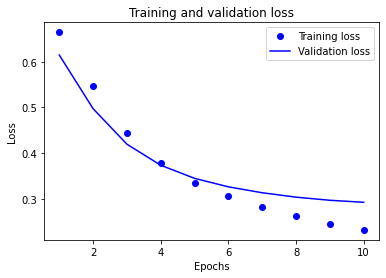

In [29]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

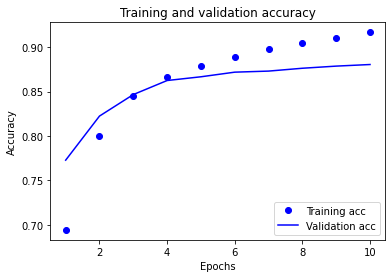

In [30]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [31]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)


  1/782 [..............................] - ETA: 2:39 - loss: 0.2935 - accuracy: 0.8750


 15/782 [..............................] - ETA: 2s - loss: 0.3034 - accuracy: 0.8646  


 29/782 [>.............................] - ETA: 2s - loss: 0.3139 - accuracy: 0.8631


 44/782 [>.............................] - ETA: 2s - loss: 0.3059 - accuracy: 0.8665


 58/782 [=>............................] - ETA: 2s - loss: 0.2991 - accuracy: 0.8718


 73/782 [=>............................] - ETA: 2s - loss: 0.2962 - accuracy: 0.8771


 88/782 [==>...........................] - ETA: 2s - loss: 0.2951 - accuracy: 0.8768


102/782 [==>...........................] - ETA: 2s - loss: 0.2990 - accuracy: 0.8744


117/782 [===>..........................] - ETA: 2s - loss: 0.3111 - accuracy: 0.8694


132/782 [====>.........................] - ETA: 2s - loss: 0.3092 - accuracy: 0.8688


147/782 [====>.........................] - ETA: 2s - loss: 0.3079 - accuracy: 0.8695


161/782 [=====>........................] - ETA: 2s - loss: 0.3096 - accuracy: 0.8686


176/782 [=====>........................] - ETA: 2s - loss: 0.3107 - accuracy: 0.8690


192/782 [======>.......................] - ETA: 2s - loss: 0.3086 - accuracy: 0.8706


207/782 [======>.......................] - ETA: 2s - loss: 0.3075 - accuracy: 0.8712


222/782 [=======>......................] - ETA: 1s - loss: 0.3090 - accuracy: 0.8702


236/782 [========>.....................] - ETA: 1s - loss: 0.3110 - accuracy: 0.8677


251/782 [========>.....................] - ETA: 1s - loss: 0.3111 - accuracy: 0.8687


266/782 [=========>....................] - ETA: 1s - loss: 0.3083 - accuracy: 0.8704


281/782 [=========>....................] - ETA: 1s - loss: 0.3104 - accuracy: 0.8693


296/782 [==========>...................] - ETA: 1s - loss: 0.3107 - accuracy: 0.8700


311/782 [==========>...................] - ETA: 1s - loss: 0.3106 - accuracy: 0.8705


326/782 [===========>..................] - ETA: 1s - loss: 0.3103 - accuracy: 0.8707


341/782 [============>.................] - ETA: 1s - loss: 0.3084 - accuracy: 0.8714


356/782 [============>.................] - ETA: 1s - loss: 0.3082 - accuracy: 0.8714


371/782 [=============>................] - ETA: 1s - loss: 0.3076 - accuracy: 0.8715


386/782 [=============>................] - ETA: 1s - loss: 0.3071 - accuracy: 0.8718


401/782 [==============>...............] - ETA: 1s - loss: 0.3076 - accuracy: 0.8719


416/782 [==============>...............] - ETA: 1s - loss: 0.3075 - accuracy: 0.8722


431/782 [===============>..............] - ETA: 1s - loss: 0.3055 - accuracy: 0.8735


446/782 [================>.............] - ETA: 1s - loss: 0.3054 - accuracy: 0.8737


461/782 [================>.............] - ETA: 1s - loss: 0.3055 - accuracy: 0.8743


476/782 [=================>............] - ETA: 1s - loss: 0.3061 - accuracy: 0.8740


491/782 [=================>............] - ETA: 1s - loss: 0.3072 - accuracy: 0.8732


506/782 [==================>...........] - ETA: 0s - loss: 0.3081 - accuracy: 0.8728


520/782 [==================>...........] - ETA: 0s - loss: 0.3088 - accuracy: 0.8730


534/782 [===================>..........] - ETA: 0s - loss: 0.3087 - accuracy: 0.8733


549/782 [====================>.........] - ETA: 0s - loss: 0.3091 - accuracy: 0.8732


564/782 [====================>.........] - ETA: 0s - loss: 0.3086 - accuracy: 0.8734


579/782 [=====================>........] - ETA: 0s - loss: 0.3086 - accuracy: 0.8737


594/782 [=====================>........] - ETA: 0s - loss: 0.3100 - accuracy: 0.8731


609/782 [======================>.......] - ETA: 0s - loss: 0.3099 - accuracy: 0.8732


623/782 [======================>.......] - ETA: 0s - loss: 0.3096 - accuracy: 0.8731


638/782 [=======================>......] - ETA: 0s - loss: 0.3100 - accuracy: 0.8733


653/782 [========================>.....] - ETA: 0s - loss: 0.3093 - accuracy: 0.8734


668/782 [========================>.....] - ETA: 0s - loss: 0.3101 - accuracy: 0.8728


683/782 [=========================>....] - ETA: 0s - loss: 0.3104 - accuracy: 0.8728


698/782 [=========================>....] - ETA: 0s - loss: 0.3110 - accuracy: 0.8726


713/782 [==========================>...] - ETA: 0s - loss: 0.3111 - accuracy: 0.8727


728/782 [==========================>...] - ETA: 0s - loss: 0.3110 - accuracy: 0.8727


743/782 [===========================>..] - ETA: 0s - loss: 0.3105 - accuracy: 0.8728


758/782 [============================>.] - ETA: 0s - loss: 0.3109 - accuracy: 0.8725


773/782 [============================>.] - ETA: 0s - loss: 0.3106 - accuracy: 0.8726


782/782 [==============================] - 3s 3ms/step - loss: 0.3102 - accuracy: 0.8728


0.8728399872779846


In [32]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

array([[0.60190666],
       [0.4210796 ],
       [0.34067595]], dtype=float32)